# ПРАКТИЧЕСКИЕ ЗАДАЧИ

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import pandahouse

## Task 1

Проводить исследования и интерпретировать их результаты - одна из главных задач аналитика, но для правильной постановки гипотезы нужно понимать, что происходит в данных.

Этим мы и займёмся - давайте познакомимся с нашими данными чуть ближе, чем названия колонок и их содержание! Первое, что мы можем сделать - это посчитать описательные статистики по лайкам и просмотрам.

Укажите, что из этого НЕ ХАРАКТЕРНО для наших данных. Возможно, вы догадаетесь о правильном ответе даже без описательных статистик :)
* По мерам центральной тенденции просмотры опережают лайки (-)
* Самые популярные посты собирают миллионы просмотров (+)
* Медиана лайков приблизительно такая же, как и среднее по ним же (+)

In [2]:
# Подключаемся к БД
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220420'
}

In [3]:
# Как выглядит наша таблица
q = '''
       SELECT * 
       FROM simulator_20220420.feed_actions
       LIMIT 5
    '''
pandahouse.read_clickhouse(q, connection=connection)

,user_id,post_id,action,time,gender,age,country,city,os,source,exp_group
0,130415,5206,view,2022-05-21 16:04:46,0,19,Russia,Chelyabinsk,Android,organic,2
1,135992,5392,view,2022-05-21 16:04:46,0,27,Russia,Ulyanovsk,iOS,organic,0
2,147177,5112,view,2022-05-21 16:04:46,1,14,Russia,Nizhniy Novgorod,Android,organic,4
3,154846,5319,view,2022-05-21 16:04:46,1,23,Russia,Shatura,Android,organic,0
4,158128,5239,view,2022-05-21 16:04:46,1,17,Russia,Vladivostok,Android,organic,1


In [6]:
# Лайки и просмотры в feed
q = '''
       SELECT
           user_id,
           toDate(time) as day, 
           countIf(action='like') as likes,
           countIf(action='view') as views
        FROM 
            simulator_20220420.feed_actions
        GROUP BY
            user_id, day
    '''
views_likes_df = pandahouse.read_clickhouse(q, connection=connection)

In [7]:
views_likes_df.head()

,user_id,day,likes,views
0,144479,2022-04-24,11,30
1,131913,2022-05-09,12,28
2,109862,2022-04-09,11,46
3,4693,2022-03-30,10,35
4,20107,2022-04-17,3,29


In [8]:
# Меры центральной тенденции для лайков и просмотров
views_likes_daily_df = views_likes_df.groupby('day', as_index=False).agg({'views':'sum', 'likes':'sum'})

# Среднее количество просмотров 
print('Среднее количество просмотров:', views_likes_daily_df['views'].mean())
# Среднее количество лайков 
print('Среднее количество лайков:', views_likes_daily_df['likes'].mean())

# Медиана просмотров 
print('Медиана просмотров:', views_likes_daily_df['views'].median())
# Медиана лайков 
print('Медиана лайков:', views_likes_daily_df['likes'].median())

print('\n1. По мерам центральной тенденции просмотры опережают лайки')
print('\n3. Медиана лайков приблизительно такая же, как и среднее по ним же')

Среднее количество просмотров: 543487.87
Среднее количество лайков: 114867.91
Медиана просмотров: 575051.0
Медиана лайков: 118108.0

1. По мерам центральной тенденции просмотры опережают лайки

3. Медиана лайков приблизительно такая же, как и среднее по ним же


In [9]:
# Самые популярные посты собирают миллионы просмотров?
q = '''
       SELECT
           post_id,            
           countIf(action='like') as likes,
           countIf(action='view') as views
        FROM 
            simulator_20220420.feed_actions
        GROUP BY
            post_id
    '''
views_likes_by_posts_df = pandahouse.read_clickhouse(q, connection=connection)

In [10]:
views_likes_by_posts_df.sort_values('views', ascending=False).head()

,post_id,likes,views
6238,4866,31714,104338
6051,5127,29637,97417
1133,6448,27939,92448
5569,6498,27729,91940
6636,6513,27686,91575


In [11]:
print('2. Самые популярные посты НЕ собирают миллионы просмотров')

2. Самые популярные посты НЕ собирают миллионы просмотров


## Task 2

Описательные статистики - это, конечно, хорошо. Но визуализация данных гораздо нагляднее!

Нарисуйте распределения просмотров и лайков. Какая у них форма и есть ли различия в этой форме? Выберите правильные варианты.

**NB!** Вам может помочь сравнение квантилей двух распределений через QQ-график. Перед этим их стоит z-стандартизовать, чтобы привести к общей шкале. Для большей наглядности советуем указать аргумент *line="45"*. Отклонения от линии будут означать разницу в распределениях!
* Для данных характерна положительная асимметрия
* В данных хорошо видны подгруппы
* Есть пик около нуля/единицы как для просмотров, так и для лайков
* Стандартизированные данные отличаются по своим правым "хвостам" - концам распределений
* Для данных характерна левосторонняя асимметрия

In [12]:
# Необходимые библиотеки
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot_2samples

In [13]:
# Стандартизируем распределения просмотров и лайков

# Стандартизованные просмотры
views_likes_daily_df['views_stndrtzd'] = (views_likes_daily_df['views'] - views_likes_daily_df['views'].mean()) / views_likes_daily_df['views'].std()
# Стандартизованные лайки
views_likes_daily_df['likes_stndrtzd'] = (views_likes_daily_df['likes'] - views_likes_daily_df['likes'].mean()) / views_likes_daily_df['likes'].std()

views_likes_daily_df

,day,views,likes,views_stndrtzd,likes_stndrtzd
0,2022-03-08,8208,1880,-2.815822,-2.656656
1,2022-03-09,60906,13305,-2.538606,-2.388023
2,2022-03-10,125230,26996,-2.200232,-2.066110
3,2022-03-11,150516,32498,-2.067215,-1.936743
4,2022-03-12,179308,37450,-1.915756,-1.820308
...,...,...,...,...,...
95,2022-06-11,742961,162880,1.049322,1.128896
96,2022-06-12,857070,191695,1.649588,1.806416
97,2022-06-13,802837,179118,1.364297,1.510696
98,2022-06-14,755495,162101,1.115256,1.110580


In [14]:
# Стандартизируем распределения просмотров и лайков по постам

# Стандартизованные просмотры
views_likes_by_posts_df['views_stndrtzd'] = (views_likes_by_posts_df['views'] - views_likes_by_posts_df['views'].mean()) / views_likes_by_posts_df['views'].std()
# Стандартизованные лайки
views_likes_by_posts_df['likes_stndrtzd'] = (views_likes_by_posts_df['likes'] - views_likes_by_posts_df['likes'].mean()) / views_likes_by_posts_df['likes'].std()

In [18]:
sns.set(rc={"figure.figsize":(18, 10)})

/nfs/env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


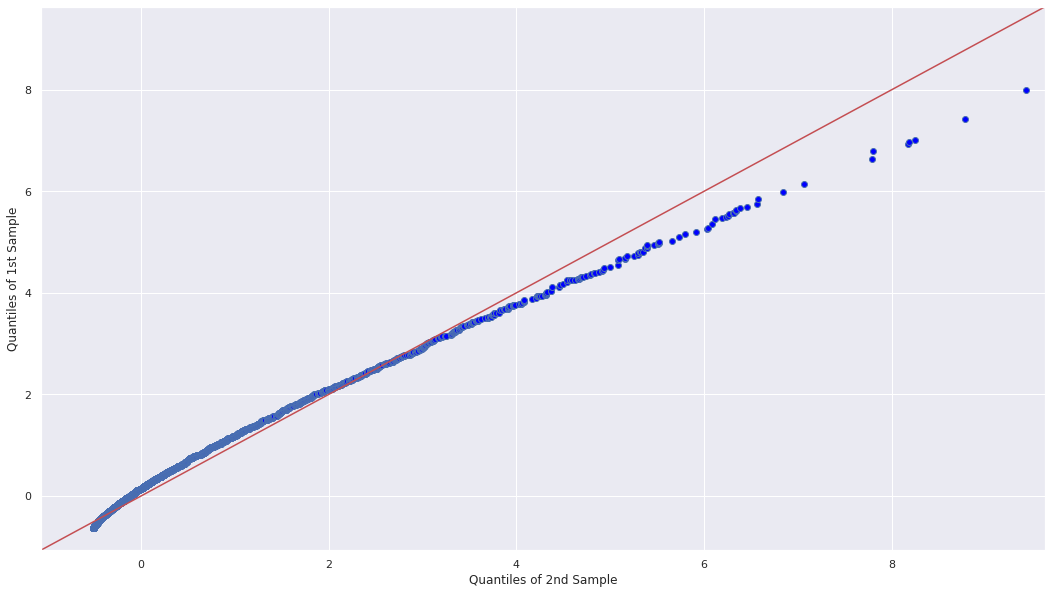

In [19]:
# QQ-plot
pp_x = sm.ProbPlot(np.array(views_likes_by_posts_df['views_stndrtzd']))
pp_y = sm.ProbPlot(np.array(views_likes_by_posts_df['likes_stndrtzd']))

qqplot_2samples(pp_x, pp_y, line="45")
plt.show()

# Распределения отличаются друг от друга в своих "правых хвостах"

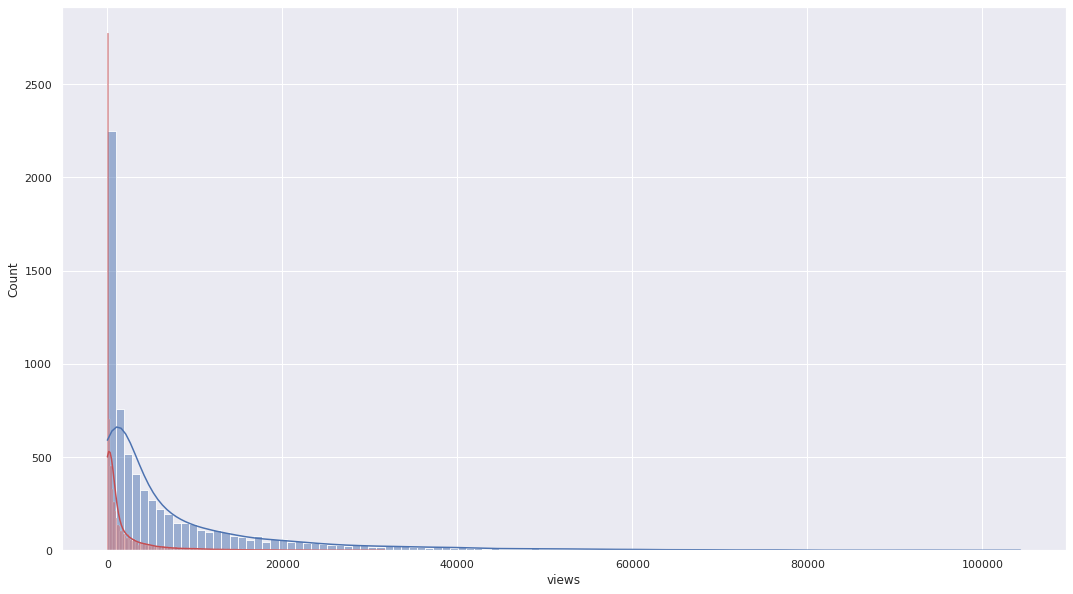

In [20]:
# Посмотрим на гистограммы распределения views и likes
sns.set(rc={"figure.figsize":(18, 10)})

sns.histplot(data=views_likes_by_posts_df, x="views", color='b', kde=True)
sns.histplot(data=views_likes_by_posts_df, x="likes", color='r', kde=True)
plt.show()

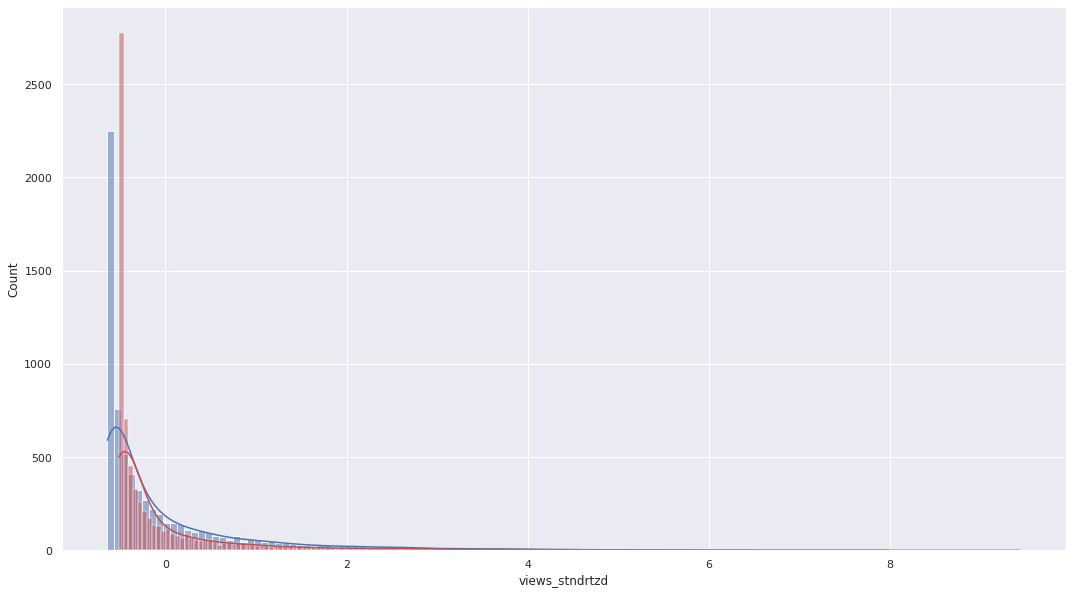

In [21]:
# Посмотрим на гистограммы распределения стандартизованных views и likes
sns.set(rc={"figure.figsize":(18, 10)})

sns.histplot(data=views_likes_by_posts_df, x="views_stndrtzd", color='b', kde=True)
sns.histplot(data=views_likes_by_posts_df, x="likes_stndrtzd", color='r', kde=True)
plt.show()

In [22]:
# Проверим коэффициент асимметрии наших данных
from scipy.stats import skew

# Коэффициент асимметрии просмотров - положительный
print('Коэффициент асимметрии просмотров:', round(skew(views_likes_by_posts_df['views']),2))
# Коэффициент асимметрии лайков - тоже положительный
print('Коэффициент асимметрии лайков:', round(skew(views_likes_by_posts_df['likes']),2))

Коэффициент асимметрии просмотров: 2.76
Коэффициент асимметрии лайков: 3.5


1. Мы видим, что для **данных характерна положительная асимметрия** (т.е. среднее и медиана больше моды наших данных - "горб" слева) (+).
2. Подгруппы в данных не наблюдаются -> В данных хорошо видны подгруппы (-)
3. **Есть пик около нуля/единицы как для просмотров, так и для лайков** (+)
4. **Стандартизированные данные отличаются по своим правым "хвостам" - концам распределений** (+)
5. Для данных характерна левосторонняя асимметрия (когда среднее меньше моды - "горб" справа) (-)

## Task 3

"Сырые" лайки и просмотры могут быть познавательными сами по себе, но качество поста можно оценить не только по ним. Полезной может оказаться такая метрика как CTR - в данном случае это отношение количества лайков ко всем просмотрам данного поста. Также важную информацию может дать время существования поста - насколько продолжительное время конкретный пост смотрят и лайкают.

Посчитайте CTR и время существования для каждого из постов (от первого просмотра поста). Затем:

Нарисуйте их распределения  
Постройте корреляционную матрицу между ними, просмотрами и лайками  
Визуализируйте все эти взаимосвязи в виде диаграмм рассеяния  
Какие суждения об этих величинах верны? Суждение может быть одно, а может быть несколько.
* Между количеством лайков и временем существования поста связь линейная
* По сравнению с просмотрами и лайками CTR менее асимметричен
* Сильнее всего коррелируют CTR и время существования поста
* В среднем посты "живут" пять дней

In [36]:
# Посчитаем CTR и время существования для каждого из постов
q = '''
    WITH posts_data AS
        (
        SELECT 
            post_id, 
            MIN(time) as start_date,
            MAX(time) as end_date,
            countIf(action='like') as likes,
            countIf(action='view') as views,
            likes / views as CTR
        FROM 
            simulator_20220420.feed_actions
        GROUP BY
            post_id
        )
    SELECT
        post_id,
        likes,
        views,
        CTR as ctr,
        (end_date - start_date) as lifetime_sec
    FROM
        posts_data
    '''
posts_df = pandahouse.read_clickhouse(q, connection=connection)

In [37]:
posts_df.head()

,post_id,likes,views,ctr,lifetime_sec
0,610,2271,10727,0.211709,297341
1,4660,192,1637,0.117288,71628
2,4742,1,11,0.090909,1231
3,720,1089,6120,0.177941,222573
4,948,2051,9846,0.208308,259589


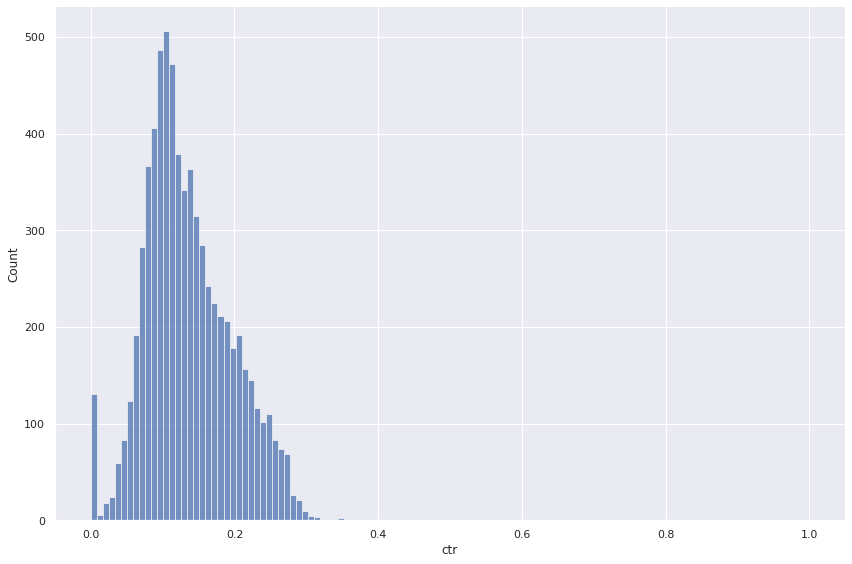

In [40]:
# Распределение CTR
sns.displot(posts_df, x="ctr", height=8, aspect=1.5)
plt.show()

# Асимметрия присутствует

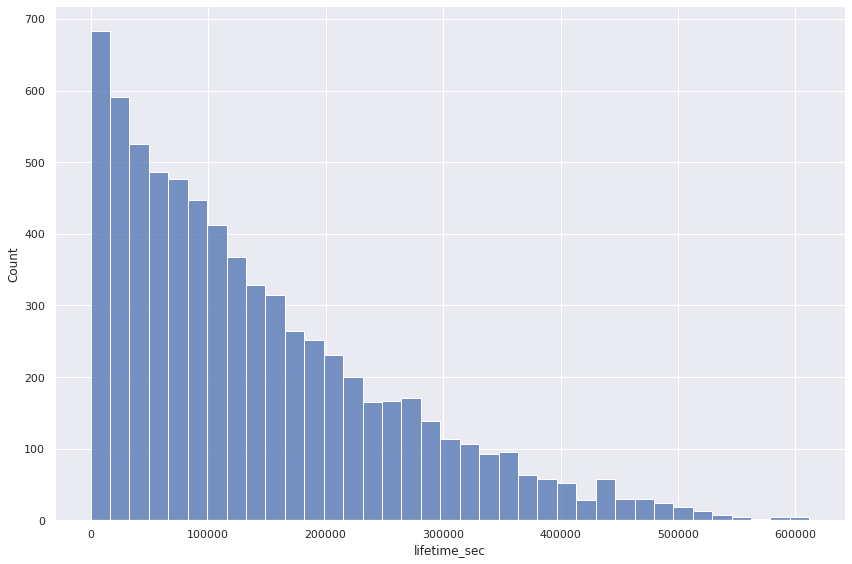

In [41]:
# Распределение lifetime
sns.displot(posts_df, x="lifetime_sec", height=8, aspect=1.5)
plt.show()

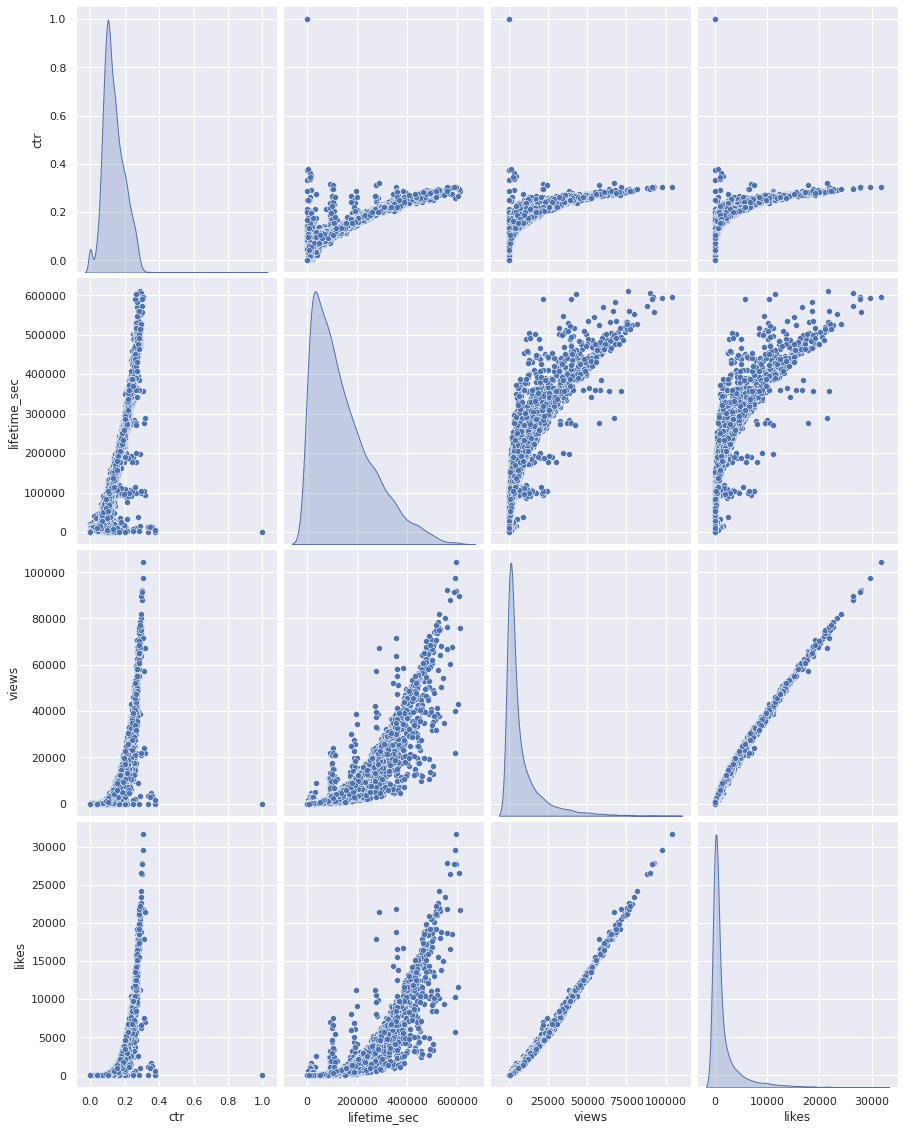

In [44]:
# Визуализируем взаимосвязи между CTR, lifetime, просмотрами и лайками в виде диаграмм рассеяния
sns.pairplot(posts_df[['ctr', 'lifetime_sec', 'views', 'likes']], diag_kind='kde', height=4, aspect=0.8)
plt.show()

In [45]:
# Таблица корреляции
posts_df[['ctr', 'lifetime_sec', 'views', 'likes']].corr(method='kendall')

# Лайки и посты коррелируют сильнее всего

,ctr,lifetime_sec,views,likes
ctr,1.000000,0.820371,0.778989,0.816262
lifetime_sec,0.820371,1.000000,0.857449,0.872373
views,0.778989,0.857449,1.000000,0.964355
likes,0.816262,0.872373,0.964355,1.000000


In [39]:
# Среднее время жизни постов, в днях
posts_df.lifetime_sec.mean()/3600

39.25369033493126

1. Между количеством лайков и временем существования поста связь линейная (-)
2. По сравнению с просмотрами и лайками CTR менее асимметричен (+)
3. Сильнее всего коррелируют CTR и время существования поста (-)
4. В среднем посты "живут" пять дней (-)

## Task 4

Всё это время мы оценивали наши данные "в статике". Давайте теперь обратимся к их динамике! Попробуем определить, что вообще приводит к изменениям в наших метриках - в самом первом приближении.

Нарисуйте дневную динамику активности уникальных пользователей, а затем просмотра уникальных постов.

In [48]:
# Посчитаем DAU
q = '''
    SELECT
        toDate(time) as day, 
        uniqExact(user_id) as num_of_users
    FROM
        simulator_20220420.feed_actions
    GROUP BY
        day
    '''
DAU_df = pandahouse.read_clickhouse(q, connection=connection)

<AxesSubplot:xlabel='day', ylabel='num_of_users'>

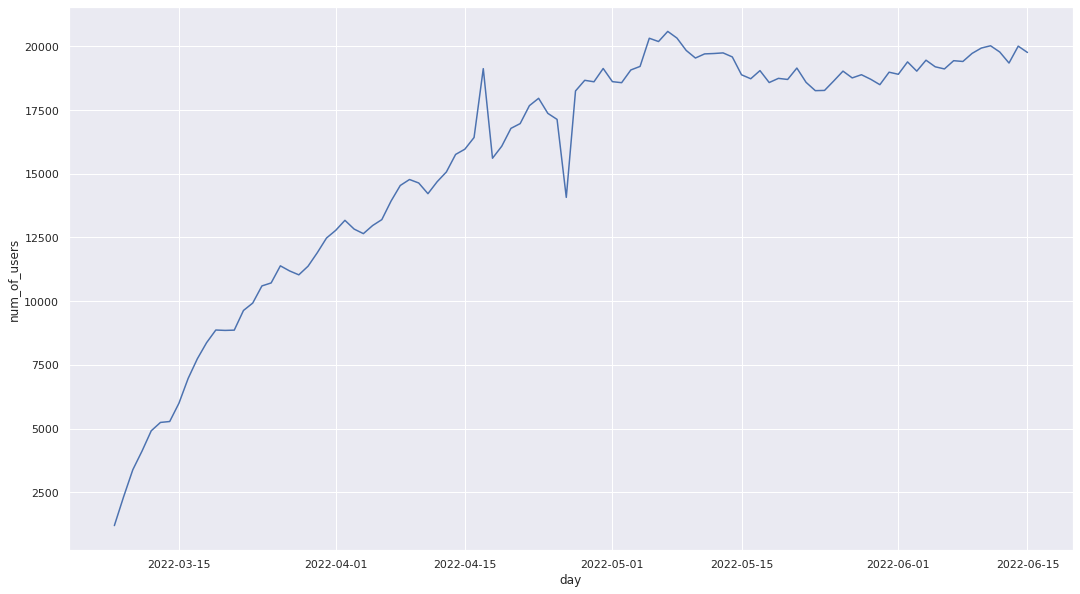

In [49]:
# Дневная динамика активности уникальных пользователей
sns.lineplot(data=DAU_df, x='day', y='num_of_users')

# Мы видим постоянный рост с небольшими флуктуациями

<AxesSubplot:xlabel='views', ylabel='Count'>

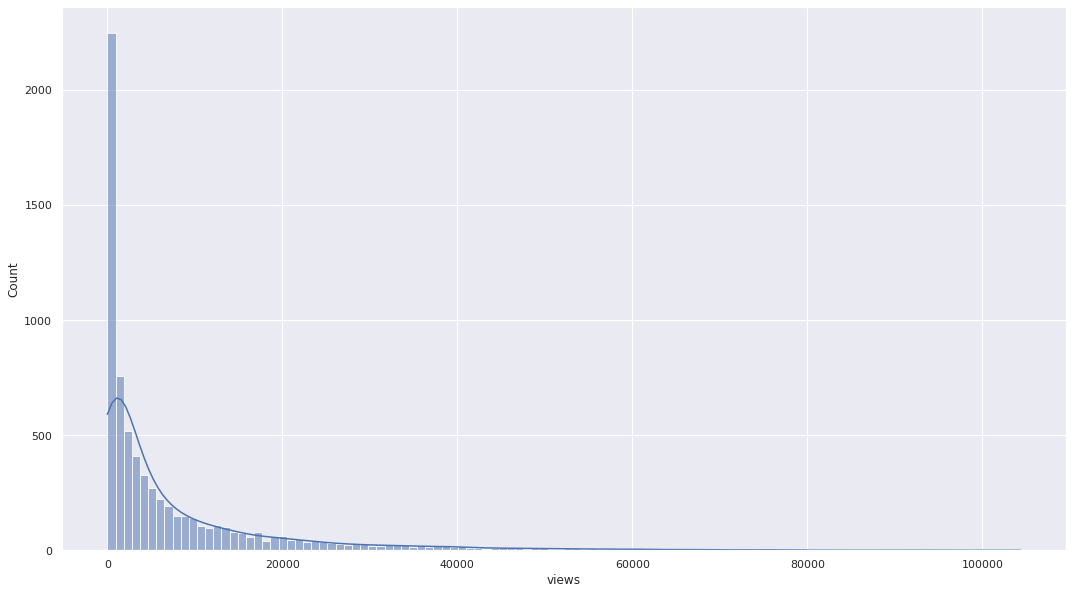

In [58]:
# Просмотры уникальных постов
sns.histplot(data=views_likes_by_posts_df, x="views", color='b', kde=True)

In [59]:
# Unique posts daily
q = '''
    SELECT
        toDate(time) as day,
        uniqExact(post_id) as posts
    FROM
        simulator_20220420.feed_actions
    GROUP BY
        day
    ORDER BY
        day
    '''
posts = pandahouse.read_clickhouse(q, connection=connection)

<AxesSubplot:xlabel='day', ylabel='posts'>

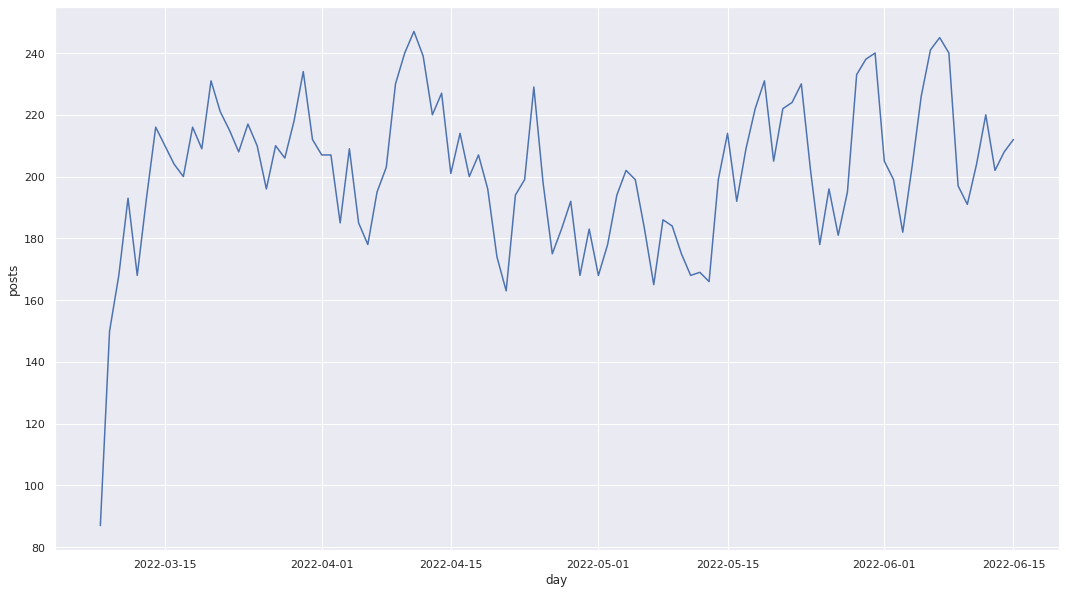

In [61]:
# Уникальные посты по дням
sns.lineplot(data=posts, x='day', y='posts')

Уникальные пользователи - **Постоянный рост с небольшими флуктуациями**

Просмотры уникальных постов - **Резкий рост в начале, затем случайные колебания вокруг одного уровня**

## Task 5

Мы посмотрели как на вклад пользователей, так и вклад постов в общую динамику просмотров и лайков. Однако не менее полезной может оказаться декомпозиция временного ряда на компоненты - чтобы выделить отдельные составляющие части процесса.

Возьмите почасовую динамику активности за весь период и проанализируйте её функцией *statsmodels.tsa.seasonal.STL*

In [62]:
from statsmodels.tsa.seasonal import STL

In [63]:
# Почасовая динамика активности за весь период
q = '''
    SELECT
        toStartOfHour(time) as day_h, 
        COUNT(user_id) as actions
    FROM
        simulator_20220420.feed_actions
    GROUP BY
        day_h
    ORDER BY
        day_h
    '''
actions_by_hour_df = pandahouse.read_clickhouse(q, connection=connection)

In [64]:
actions_by_hour_df.set_index('day_h', inplace=True)

In [65]:
actions_by_hour_df.head()

,actions
day_h,
2022-03-08 00:00:00,61
2022-03-08 01:00:00,65
2022-03-08 02:00:00,45
2022-03-08 03:00:00,30
2022-03-08 04:00:00,38


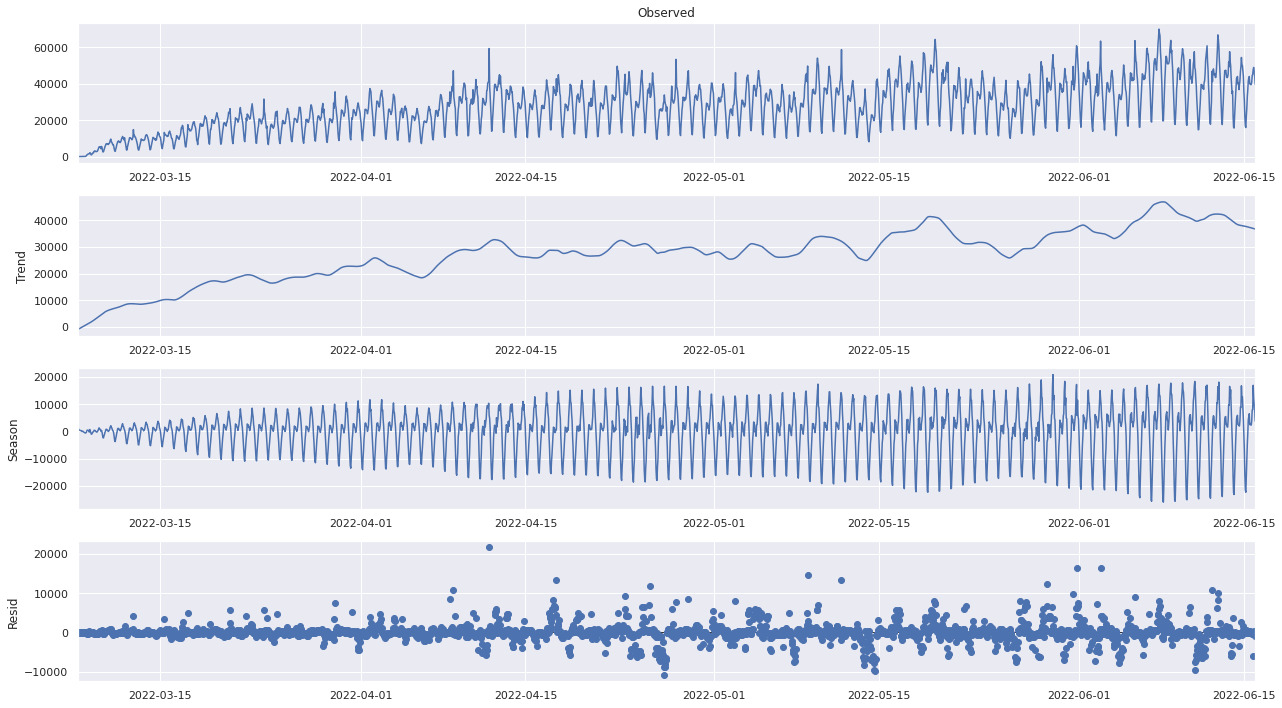

In [68]:
res = STL(actions_by_hour_df, robust=True).fit() # robust - менее подверженная выбросам декомпозиция
res.plot()
plt.show()

Первый график - **Оригинальный временной ряд**

Третий график - **Повторяющиеся дневные регулярности в данных**

Четвёртый график - **Остатки модели**

Второй график - **Общий тренд активности**

## Task 6

Вы могли заметить из прошлого задания, что просмотры постов "колеблются" в течение дня. Вопрос: а отличается ли распределение дневной активности пользователей от распределения публикации постов? В качестве прокси времени публикации возьмите время первого просмотра поста.

Визуализируйте оба распределения для каждого часа дня.

In [71]:
# Распределение дневной активности пользователей
q = '''
    SELECT
        toDate(time) as day,
        toHour(time) as hour,
        COUNT(user_id) as actions
    FROM
        simulator_20220420.feed_actions
    GROUP BY
        day, hour
    ORDER BY
        day, hour
    '''
actions_by_hour_df = pandahouse.read_clickhouse(q, connection=connection)

In [72]:
actions_by_hour_df.tail()

,day,hour,actions
2395,2022-06-15,19,47816
2396,2022-06-15,20,49046
2397,2022-06-15,21,47360
2398,2022-06-15,22,44073
2399,2022-06-15,23,39789


In [73]:
# Распределение публикации постов в течение дня
# В качестве прокси времени публикации возьмите время первого просмотра поста
q = '''
    SELECT
        hour,
        COUNT(DISTINCT post_id) as posts
    FROM
    (SELECT
        post_id,
        publication_time,
        toHour(publication_time) as hour
    FROM
    (SELECT
        post_id,
        MIN(toStartOfHour(time)) as publication_time
    FROM
        simulator_20220420.feed_actions
    GROUP BY
        post_id
    ORDER BY
        publication_time))
    GROUP BY
        hour 
    '''
posts_by_hour_df = pandahouse.read_clickhouse(q, connection=connection)

In [74]:
posts_by_hour_df.tail()

,hour,posts
13,19,941
14,20,1036
15,21,929
16,22,735
17,23,445


In [76]:
hours = actions_by_hour_df['hour'].unique()

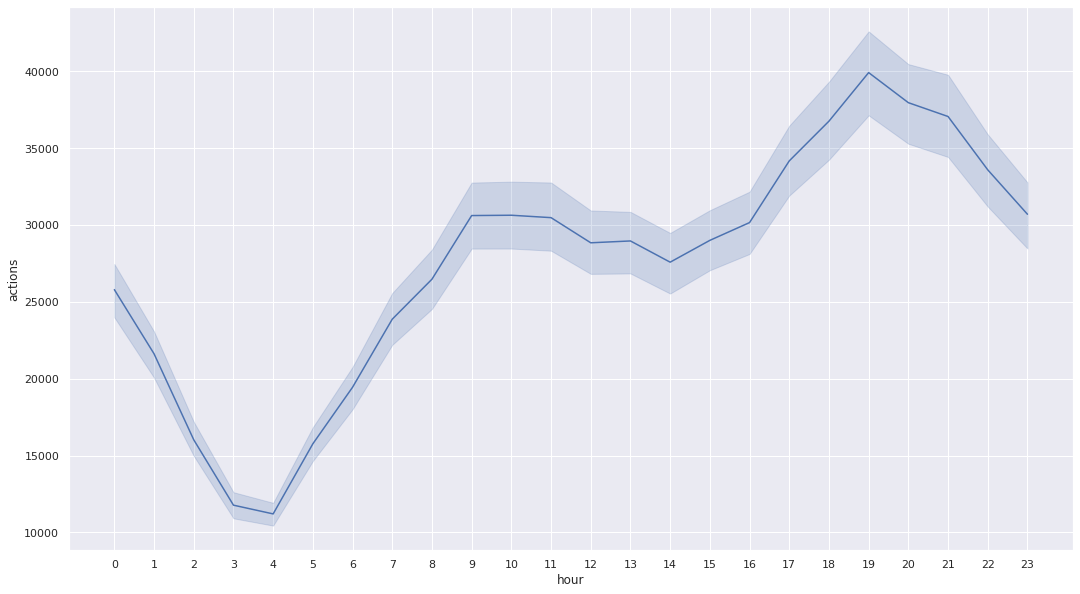

In [77]:
# График распределения дневной активности пользователей
ax = sns.lineplot(data=actions_by_hour_df, x='hour', y='actions')
ax.set(xticks=hours)
plt.show()

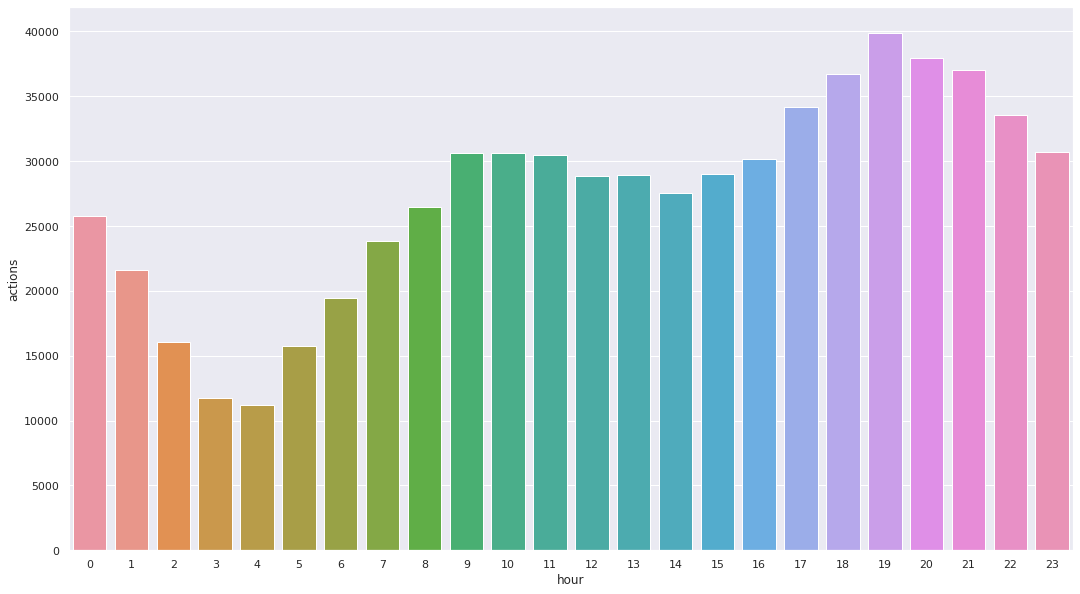

In [81]:
# График распределения дневной активности пользователей
ax = sns.barplot(data=actions_by_hour_df, x='hour', y='actions', ci=None)
ax.set(xticks=hours)
plt.show()

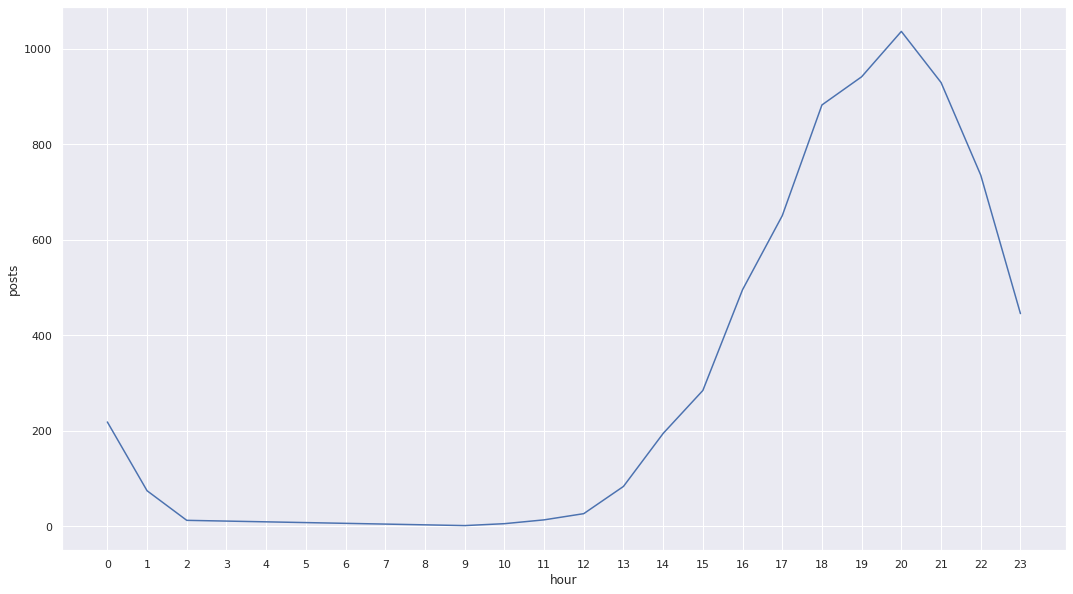

In [78]:
# График распределения публикации постов в течение дня
ax = sns.lineplot(data=posts_by_hour_df, x='hour', y='posts')
ax.set(xticks=hours)
plt.show()

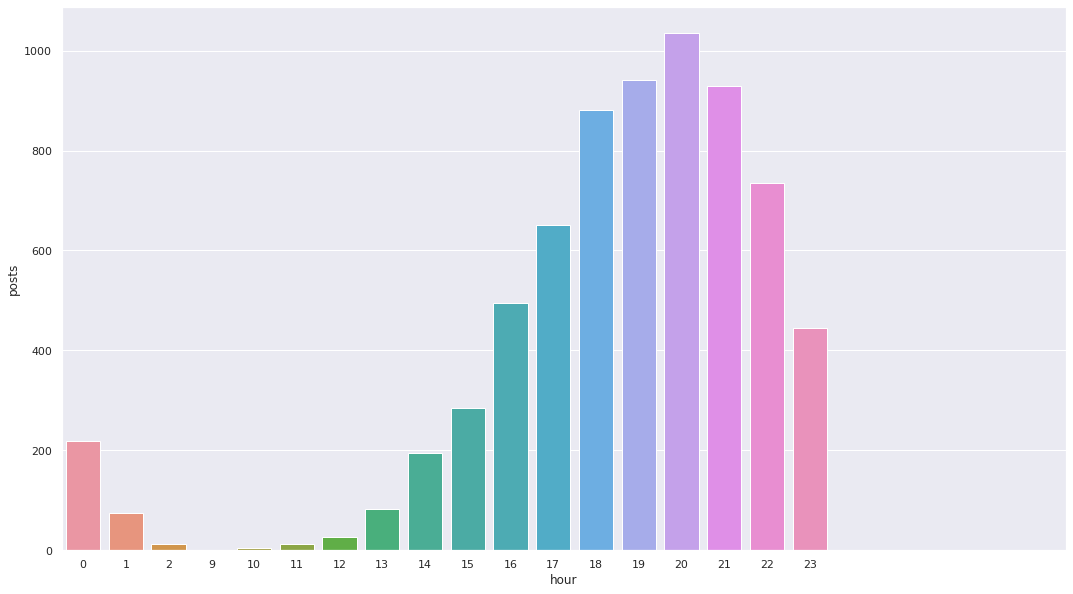

In [79]:
# График распределения публикации постов в течение дня
ax = sns.barplot(data=posts_by_hour_df, x='hour', y='posts')
ax.set(xticks=hours)
plt.show()

1. Для активности пользователей характерен линейный рост в течение дня, сопровождающийся падением (-)
2. **Больше всего постов публикуется в районе 8 вечера (+)**
3. Посты публикуются круглосуточно (-)
4. **Пики активности пользователей и публикации постов не совпадают (+)**
5. **Примерно с 9 утра до 4 вечера активность пользователей одинаковая, с небольшой "просадкой" посередине (+)**
6. Наименьшая активность пользователей наблюдается в 5 утра (-)

Fin.